In [1]:
import sys
import numpy as np
import warnings
import time
import os
import pandas as pd
import muller

muller_dataset_root_path = "/home/dyvm6xra/dyvm6xrauser08/sherry/muller_dataset/"

In [2]:
# The CIFAR10 dataset download and construction
import torch
import time
from torchvision.datasets import CIFAR10
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
#from test_scripts.config import settings as st


DATA_DIR = Path("/home/dyvm6xra/dyvm6xrauser08/sherry/data/")
DATA_DIR /= "cifar10"
DATA_DIR /= "shared"

# Class Names for Filtering
# "airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"
# See https://www.cs.toronto.edu/~kriz/cifar.html
LABELS_DICT = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}


def get_size(mode="train"):
    if mode == "test":
        return 1000
    else:
        N = 50000
        VAL_SIZE = int(N * 0)
        if mode == "train":
            return N - VAL_SIZE
        else:
            return VAL_SIZE


class Cifar10Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, mode, train=True, transform=None, download=False):
        self.root_dir = Path(root_dir) / mode
        self.mode = mode
        self.transform = transform
        self.is_train = train

        if download and not self.root_dir.is_dir():
            self._download()
        else:
            # print("Already exists. Skipping")
            pass

    def _len(self):
        if self.is_train:
            return get_size("train") + get_size("val")
        else:
            return get_size("test")

    def _download(self):
        original_path = self.root_dir.parent / f"original_{'train' if self.is_train else 'test'}"
        ds = CIFAR10(original_path, train=self.is_train, download=True)
        self.root_dir.mkdir(parents=True, exist_ok=True)
        for i, sample in enumerate(ds):
            if i % 100 == 0:
                print(f"{i} / {self._len()}", end="\r", flush=True)

            img, cls = sample
            cls = str(cls)
            path = self.root_dir / f"{i}.jpeg"
            img.save(path)
            with open(path.with_suffix(".txt"), "w") as fh:
                fh.write(cls)

    def __len__(self):
        return self._len()

    def __getitem__(self, idx):
        path = self.root_dir / f"{idx}.jpeg"
        with open(path.with_suffix(".txt"), "r") as fh:
            cls = int(fh.read())
        return path, cls

    def __iter__(self):
        for i in range(get_size(self.mode)):
                yield self.__getitem__(i)


def get_cifar10(mode="train", download=True, transform=None):

    is_train = mode in ["train", "val"]  # TODO: why?
    path = DATA_DIR
    if is_train:
        path /= "train"
    else:
        path /= "test"

    dataset = Cifar10Dataset(DATA_DIR, mode, train=is_train, download=download, transform=transform)

    gen = torch.Generator()
    gen.manual_seed(0)

    if is_train:
        ds_train, ds_val = torch.utils.data.random_split(
            dataset, [get_size("train"), get_size("val")], generator=gen
        )
        if mode == "train":
            return ds_train

        if mode == "val":
            return ds_val
    else:
        return dataset

In [3]:
# The COCO2017 dataset download and preparation
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
import os
import json
import numpy as np


class Coco2017Dataset(Dataset):

    def __init__(self, train=False, transform=None, download=True):
        self.transform = transform
        self.root_dir = "/home/dyvm6xra/dyvm6xrauser08/sherry/data/"

        if download and not self.root_dir.is_dir():
            self._download()

        self.annotations_root = os.path.join(self.root_dir, "annotations")  # need to change the path accordingly
        if train:
            self.annotations_json = os.path.join(self.annotations_root, "instances_train2017.json") # need to change the path accordingly
            self.image_root = os.path.join(self.root_dir, "train2017")  # need to change the path accordingly
        else:
            self.annotations_json = os.path.join(self.annotations_root, "instances_val2017.json") # need to change the path accordingly
            self.image_root = os.path.join(self.root_dir, "val2017")  # need to change the path accordingly

        assert os.path.exists(self.annotations_json), "{} file not exist.".format(self.annotations_json)

        json_file = open(self.annotations_json, "r")
        self.coco_dict = json.load(json_file)  # a dict contains 5 dicts: "info", "licenses", "images",
        # "annotations", and "categories"
        self.annotation_image = {}  # a blank dict
        annotation_img = self.coco_dict["annotations"]  # get the "annotations" dict
        for temp in annotation_img:  # temp is every object in the annotations dict
            temp_append = []

            image_id = temp["image_id"]  # get the corresponding img id of the object
            area = temp["area"]  # get the areas of the bounding boxes
            bbox = temp["bbox"]  # get the bounding boxes of the object
            category_id = temp["category_id"]  # get the category id of the object
            id = temp["id"]  # get the unique id of the annotation
            iscrowd = temp["iscrowd"]
            segmentation = temp["segmentation"]

            temp_append.append(area)
            temp_append.append(bbox)
            temp_append.append(category_id)
            temp_append.append(id)
            temp_append.append(iscrowd)
            temp_append.append(segmentation)  # temp_append = [area, bbox, category_id, id, iscrowd, segmentation] 
            if self.annotation_image.__contains__(image_id):  # image_id is already a key in the annotation_image dict
                self.annotation_image[image_id].append(temp_append)  # self.annotation_image = {image_id: [area,
                # bbox, category_id, id, iscrowd, segmentation]} 
            else:  # image_id is not a key in the annotation_image yet
                self.annotation_image[image_id] = []
                self.annotation_image[image_id].append(temp_append)  # self.bbox_image = {image_id: [area, bbox,
                # category_id, id, iscrowd, segmentation]} 

    def _download(self):
        # TODO: write a reminder if the file does not exists
        print(f"We expect that there is a directory {self.root_dir}, with /annotations and /images inside.")
        pass

    def __len__(self):
        _, _, files = next(os.walk(self.image_root))  # number of images under the image folder
        return len(files)

    def __getitem__(self, idx):  # idx = 0,1,2,...
        image_list = self.coco_dict["images"]  # images info
        pic_name = image_list[idx]["file_name"]  # [image_id].jpg
        pic_path = os.path.join(self.image_root, pic_name)  # path of the specific image
        image = Image.open(pic_path)  # load the image

        target = {}

        area = []
        bbox = []
        category_id = []
        id = []
        iscrowd = []
        segmentation = []

        if self.annotation_image.__contains__(image_list[idx]["id"]):  # annotation_image has the key
            for annotations in self.annotation_image[image_list[idx]["id"]]:  # a single image may have several objects
                area.append(annotations[0])
                bbox.append(annotations[1])
                category_id.append(annotations[2])
                id.append(annotations[3])
                iscrowd.append(annotations[4])
                segmentation.append(annotations[5])  # list of lists

            target["area"] = np.array(area, dtype=np.float32)
            target["bbox"] = np.array(bbox, dtype=np.float32)
            target["category_id"] = np.array(category_id)
            target["id"] = np.array(id)
            target["image_id"] = np.array(image_list[idx]["id"])
            target["iscrowd"] = np.array(iscrowd)
            target["segmentation"] = segmentation
        else:
            target["area"] = np.array([0], dtype=np.float32)
            target["bbox"] = np.array([[0, 0, 0, 0]], dtype=np.float32)
            target["category_id"] = np.array([0])
            target["id"] = np.array([0])
            target["image_id"] = np.array(image_list[idx]["id"])
            target["iscrowd"] = np.array([-1])
            target["segmentation"] = np.array([0])

        if self.transform is not None:
            print("check")
            image, target = self.transform(image, target)  # a single image & its labels and bounding boxes

        return pic_path, target

In [4]:
# The dataframe representation
import pandas as pd

def str_to_pandas(ds):
    data = {}
    for k, v in ds.numpy().items():
        data[k] = list(v.flatten())
    df = pd.DataFrame(data, columns=list(ds.numpy().keys()))
    return df

def np_to_pandas(ds, col_list, start, end):
    data = {}
    for col in col_list:
        data[col] = ds[col].numpy(aslist=True)[start: end]
    df = pd.DataFrame(data, columns=col_list)
    return df

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def plot_image_with_bboxes(image, bboxes, category_ids=None, class_names=None):
    """
    在图像上绘制边界框
    
    参数:
    image: numpy数组格式的图片
    bboxes: COCO格式的bbox列表 [[x_min, y_min, width, height], ...]
    category_ids: 每个bbox对应的类别ID列表（可选）
    class_names: 类别ID到名称的映射字典（可选）
    """
    # 创建图形和坐标轴
    fig, ax = plt.subplots()
    
    # 显示图像
    ax.imshow(image)
    
    # 为不同的类别设置不同的颜色
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    # 绘制每个bbox
    for i, bbox in enumerate(bboxes):
        x_min, y_min, width, height = bbox
        
        # 选择颜色（如果有类别信息）
        color = colors[i % len(colors)] if category_ids is None else colors[category_ids[i] % len(colors)]
        
        # 创建矩形框
        rect = patches.Rectangle((x_min, y_min), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
        
        # 添加矩形框到图像
        ax.add_patch(rect)
        
        # 如果有类别信息，添加标签
        if category_ids is not None and class_names is not None:
            category_id = category_ids[i]
            class_name = class_names.get(category_id, f"Class {category_id}")
            ax.text(x_min, y_min-5, class_name, 
                   bbox=dict(facecolor=color, alpha=0.7),
                   color='white', fontsize=8, weight='bold')
    
    ax.axis('off')  # 关闭坐标轴
    plt.tight_layout()
    plt.show()

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from pycocotools.coco import COCO

coco = COCO('/home/dyvm6xra/dyvm6xrauser08/sherry/data/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [8]:
def plot_image_with_bboxes(ds, local_index):

    image = ds.images[local_index].numpy()
    bboxes = ds.bbox[local_index].numpy()
    category_ids = ds.category_id[local_index].numpy()
    
    # 创建图形和坐标轴
    fig, ax = plt.subplots()
    
    # 显示图像
    ax.imshow(image)
    
    # 为不同的类别设置不同的颜色
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    # 绘制每个bbox
    for i, bbox in enumerate(bboxes):
        x_min, y_min, width, height = bbox
        
        # 选择颜色（如果有类别信息）
        color = colors[i % len(colors)] #if category_ids is None else colors[category_ids[i] % len(colors)]
        
        # 创建矩形框
        rect = patches.Rectangle((x_min, y_min), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
        
        # 添加矩形框到图像
        ax.add_patch(rect)
        
        # 如果有类别信息，添加标签
        category_name = coco.loadCats(category_ids)[i]['name']
        if category_ids is not None:
            #category_id = category_ids[i]
            #class_name = class_names.get(category_id, f"Class {category_id}")
            ax.text(x_min, y_min-5, category_name, 
                   bbox=dict(facecolor=color, alpha=0.7),
                   color='white', fontsize=8, weight='bold')
    
    ax.axis('off')  # 关闭坐标轴
    plt.tight_layout()
    plt.show()

### 1. Creating a MULLER Dataset

#### 1.1 Create an empty MULLER datatset

In [9]:
ds_toy = muller.dataset(path=muller_dataset_root_path + "toy", overwrite=True)

#### 1.2 Create Columns
MULLER support 12+ data types of different modalities, including scalars, vectors, text, images, videos, and audio, with 20+ compression formats (e.g., LZ4, JPG, PNG, MP3, MP4, AVI, WAV).

| htype | sample_compression | dtype |
| --- | --- | --- |
| image | Required (one of): bmp, dib, gif, ico, jpg, jpeg, <br>jpeg2000, pcx, png, ppm, sgi, tga, tiff, <br>webp, wmf, xbm, eps, fli, im, msp, mpo | Default: `uint8` (modification not recommended) |
| video | Required (one of): mp4, mkv, avi | Default: `uint8` (modification not recommended) |
| audio | Required (one of): flac, mp3, wav | Default: `float64` (modification not recommended) |
| class_label | Default: None (null); Optional: lz4 | Default: `uint32` (modification not recommended) |
| bbox | Default: None (null); Optional: lz4 | Default: `float32` (modification not recommended) |
| text  | Default: None (null); Optional: lz4 | Default: `str` (modification not recommended) |
| json  | Default: None (null); Optional: lz4 | - |
| list  | Default: None (null); Optional: lz4 | - |
| generic  | Default: None (null); Optional: lz4 | Default: None (undeclared, inferred from data); Declaration at creation is recommended.<br>Options: `int8`, `int16`, `int32`, `int64`, `uint8`, `uint16`, <br>`uint32`, `float32`, `float64`, `bool` |

In [10]:
ds_toy.create_tensor('labels', htype='generic', dtype='int')
ds_toy.create_tensor('categories', htype='text')
ds_toy.create_tensor('description', htype='text')

Tensor(key='description')

#### 1.3. Append data into the MULLER dataset

In [11]:
with ds_toy:
    ds_toy.labels.extend([0, 1, 2, 3, 4])
    ds_toy.categories.extend(["cat", "cat", "dog", "dog", "rabbit"])
    ds_toy.description.extend(["A majestic long-haired Maine Coon cat perched on a wooden bookshelf, staring intently at a tree outside with its bright amber eyes.", 
                           "A domestic short-hair cat with a distinctive tuxedo pattern stretching lazily across a velvet sofa in a dimly lit living room.", 
                           "An energetic Golden Retriever sprinting across a vibrant green meadow, its fur glistening under the afternoon sun as it chases a bright yellow tennis ball.", 
                           "A focused German Shepherd sitting patiently on a cobblestone street, wearing a professional service harness and looking up at its handler for the next command.", 
                           "A soft, white lop-eared rabbit nestled in a patch of clover, twitching its pink nose while nibbling on a fresh garden carrot."])

#### 1.4 Parallel data import for large dataset with multiple workers
Example 1: CIFAR10 (rows: 50000, cols: images and labels)

In [7]:
cifar = get_cifar10(mode="train", download=True, transform=None)
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

ds_cifar = muller.dataset(path=muller_dataset_root_path + "cifar", overwrite=True)
with ds_cifar:
    # Create the tensors with names of your choice.
    ds_cifar.create_tensor("images", htype="image", sample_compression="jpg")
    ds_cifar.create_tensor("labels", htype="class_label", class_names=class_names)
    
@muller.compute
def file_to_muller(data_pair, sample_out):
    # First two arguments are always default arguments containing:
    #     1st argument is an element of the input iterable (list, dataset, array,...)
    #     2nd argument is a dataset sample
    #     Other arguments are optional

    # Append the label and image to the output sample
    sample_out.labels.append(np.uint32(data_pair[1][1]))
    sample_out.images.append(muller.read(data_pair[1][0]))
    return sample_out
        
with ds_cifar:
    iter_dict = [pair for pair in enumerate(cifar)]
    file_to_muller().eval(iter_dict, ds_cifar, num_workers=8)

Evaluating file_to_muller: 100%|███████████████████████████████████████████████| 50000/50000 [00:20<00:00


In [8]:
ds_cifar.summary()


 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (50000, 32, 32, 3)   uint8    jpeg   
 labels   class_label      (50000, 1)      uint32    None   


Example 2: COCO2017-subset (rows: 5000, cols: images and 7 other columns for annotations)

In [10]:
coco = Coco2017Dataset(train=False, transform=None, download=False)
ds_coco = muller.dataset(path=(path=muller_dataset_root_path + "coco", , overwrite=True)
with ds_coco:
    ds_coco.create_tensor("area", htype="generic", sample_compression="lz4")
    ds_coco.create_tensor("bbox", htype="bbox", sample_compression="lz4")
    ds_coco.create_tensor("category_id", htype="class_label", sample_compression="lz4")
    ds_coco.create_tensor("id", htype="generic", sample_compression="lz4")
    ds_coco.create_tensor("image_id", htype="generic", sample_compression="lz4")
    ds_coco.create_tensor("images", htype="image", sample_compression="jpeg")
    ds_coco.create_tensor("iscrowd", htype="generic", sample_compression="lz4")
    ds_coco.create_tensor("segmentation", htype="list", sample_compression=None)

with ds_coco:
    for i, (image, target) in enumerate(coco):
        if i >= 5000:
            break
        print(f"Iteration {i:4d}", end="\r", flush=True, file=sys.stderr)
        ds_coco.area.append(target["area"])
        ds_coco.bbox.append(target["bbox"])
        ds_coco.category_id.append(target["category_id"])
        ds_coco.id.append(target["id"])
        ds_coco.image_id.append(target["image_id"])
        ds_coco.images.append(muller.read(image))
        ds_coco.iscrowd.append(target["iscrowd"])
        ds_coco.segmentation.append(target["segmentation"])

/home/dyvm6xra/dyvm6xrauser08/sherry/MULLER/muller/core/chunk/base_chunk.py:396: UserWarning: Grayscale images will be reshaped from (H, W) to (H, W, 1) to match tensor dimensions. This warning will be shown only once.
  warnings.warn(message)
Iteration 4999

In [11]:
ds_coco.summary()


    tensor        htype                 shape               dtype  compression
   -------       -------               -------             -------  ------- 
     area        generic            (5000, 1:63)           float32    lz4   
     bbox         bbox             (5000, 1:63, 4)         float32    lz4   
 category_id   class_label          (5000, 1:63)           uint32     lz4   
      id         generic            (5000, 1:63)            int64     lz4   
   image_id      generic              (5000, 1)             int64     lz4   
    images        image     (5000, 145:640, 200:640, 1:3)   uint8    jpeg   
   iscrowd       generic            (5000, 1:63)            int64     lz4   
 segmentation     list              (5000, 1:63)             str     None   


#### 1.4. Read raw data from HTTP/HTTPS or S3/Roma (Example)

In [ ]:
# Read from Roma or S3
from muller.core.storage import RomaProvider
credential_info = {"bucket_name":"", "region":"", "app_token":"", "vendor":""}
roma_provider = RomaProvider(root="",
                             bucket_name=credential_info.get("bucket_name"),
                             region=credential_info.get("region"),
                             app_token=credential_info.get("app_token"),
                             vendor=credential_info.get("vendor")
                             )
test_sample = muller.read(path="roma://muller_test_data_01/test/dog.157.jpg", storage=roma_provider)
ds_roma = muller.dataset(path="roma://muller_test_data_02", creds=credential_info)
with ds_roma:
    ds_roma.create_tensor(name="images", htype="image", sample_compression="jpeg")
    ds_roma.images.append(test_sample)

#### 2. Data Exploration and Analysis

In [58]:
ds_toy.summary()


   tensor      htype    shape    dtype  compression
   -------    -------  -------  -------  ------- 
   labels     generic  (5, 1)    int64    None   
 categories    text    (5, 1)     str     None   
 description   text    (5, 1)     str     None   


In [62]:
ds_toy.categories.data()

{'value': [np.str_('cat'),
  np.str_('cat'),
  np.str_('dog'),
  np.str_('dog'),
  np.str_('rabbit')]}

In [65]:
ds_toy.labels[2:4].numpy()

array([[2],
       [3]])

In [25]:
df_toy = str_to_pandas(ds_toy)
df_toy

,labels,categories,description
0,0,cat,A majestic long-haired Maine Coon cat perched ...
1,1,cat,A domestic short-hair cat with a distinctive t...
2,2,dog,An energetic Golden Retriever sprinting across...
3,3,dog,A focused German Shepherd sitting patiently on...
4,4,rabbit,"A soft, white lop-eared rabbit nestled in a pa..."


In [68]:
ds_toy.statistics()

{"num_examples": 5, "statistics": [{"column_name": "labels"}, {"column_name": "categories", "column_type": "string_text", "column_statistics": {"nan_count": 0, "nan_proportion": 0.0, "min": 3, "max": 6, "mean": 3.6, "median": 3.0, "std": 1.2, "histogram": {"hist": [4, 0, 0, 0, 0, 0, 0, 0, 0, 1], "bin_edges": [3.0, 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.699999999999999, 6.0]}}}, {"column_name": "description", "column_type": "string_text", "column_statistics": {"nan_count": 0, "nan_proportion": 0.0, "min": 125, "max": 159, "mean": 139.2, "median": 131.0, "std": 14.72956, "histogram": {"hist": [2, 1, 0, 0, 0, 0, 0, 0, 1, 1], "bin_edges": [125.0, 128.4, 131.8, 135.2, 138.6, 142.0, 145.4, 148.8, 152.2, 155.6, 159.0]}}}]}


In [69]:
ds_coco.summary()


    tensor        htype                 shape               dtype  compression
   -------       -------               -------             -------  ------- 
     area        generic            (5000, 1:63)           float32    lz4   
     bbox         bbox             (5000, 1:63, 4)         float32    lz4   
 category_id   class_label          (5000, 1:63)           uint32     lz4   
      id         generic            (5000, 1:63)            int64     lz4   
   image_id      generic              (5000, 1)             int64     lz4   
    images        image     (5000, 145:640, 200:640, 1:3)   uint8    jpeg   
   iscrowd       generic            (5000, 1:63)            int64     lz4   
 segmentation     list              (5000, 1:63)             str     None   


In [72]:
ds_coco.bbox[140:145].numpy(aslist=True)

[array([[3.3117e+02, 2.3403e+02, 2.8701e+02, 1.8324e+02],
        [1.2111e+02, 2.2346e+02, 1.5525e+02, 1.6185e+02],
        [2.7161e+02, 1.1296e+02, 1.0105e+02, 1.0156e+02],
        [2.7428e+02, 2.4000e-01, 1.7440e+01, 1.7440e+01]], dtype=float32),
 array([[ 53.75,  92.99, 372.25, 442.26],
        [342.43, 165.72,  68.22,  77.65]], dtype=float32),
 array([[3.2560e+01, 1.9721e+02, 6.0744e+02, 2.0080e+02],
        [1.4468e+02, 5.4000e-01, 4.3296e+02, 2.9046e+02]], dtype=float32),
 array([[469.16,  40.08, 170.84, 164.6 ],
        [395.72, 238.61, 243.59, 235.37],
        [274.59,  84.86, 244.33, 269.19],
        [  0.  ,  91.69, 195.24, 216.8 ],
        [536.3 , 244.3 ,  46.64,  34.65],
        [581.04, 232.32,  47.7 ,  32.83],
        [322.52, 307.42, 270.74, 112.18],
        [211.47, 147.54,  74.39,  71.24],
        [124.63, 352.91,  23.28,  47.15],
        [319.73,  34.05,  28.52,  43.05],
        [279.4 ,  89.42, 180.41, 144.6 ],
        [  0.  ,  95.63, 124.68, 149.61]], dtype=float3

In [75]:
ds_coco.images[140].numpy()

array([[[ 53,  43,  42],
        [ 55,  45,  43],
        [ 53,  43,  41],
        ...,
        [ 78,  68,  66],
        [ 87,  75,  75],
        [115, 101, 101]],

       [[ 56,  46,  45],
        [ 56,  46,  44],
        [ 54,  44,  42],
        ...,
        [ 79,  68,  66],
        [ 88,  74,  74],
        [115,  99, 100]],

       [[ 57,  45,  45],
        [ 56,  44,  44],
        [ 54,  44,  42],
        ...,
        [ 80,  69,  67],
        [ 89,  75,  75],
        [117, 101, 102]],

       ...,

       [[ 11,  11,  11],
        [ 12,  12,  12],
        [ 12,  12,  12],
        ...,
        [ 93,  91,  92],
        [ 91,  91,  91],
        [ 94,  94,  94]],

       [[ 11,  11,   9],
        [ 13,  13,  13],
        [ 13,  13,  13],
        ...,
        [ 93,  93,  93],
        [ 91,  91,  91],
        [ 92,  94,  93]],

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 13,  13,  13],
        ...,
        [ 89,  91,  90],
        [ 91,  91,  91],
        [ 91,  91,  93]]

In [57]:
df_coco = np_to_pandas(ds_coco, col_list=["image_id", "bbox", "category_id"], start=90, end=100)
df_coco

,image_id,bbox,category_id
0,[355257],"[[250.44, 11.04, 26.78, 81.94], [276.35, 213.8...","[44, 65, 1]"
1,[142092],"[[144.86, 64.32, 370.82, 332.98]]",[59]
2,[63154],"[[243.87, 195.28, 106.12, 29.75], [252.3, 137....","[42, 1]"
3,[199551],"[[0.0, 166.98, 640.0, 256.22], [123.48, 152.1,...","[65, 1]"
4,[239347],"[[206.49, 157.3, 323.24, 135.13], [334.49, 200...","[1, 32, 65, 1]"
5,[514508],"[[114.8, 119.01, 453.28, 295.92], [144.54, 159...","[72, 1, 1, 1, 1]"
6,[473237],"[[417.28, 179.83, 163.09, 167.31], [48.82, 0.0...","[62, 1, 59]"
7,[228144],"[[1.99, 74.98, 213.55, 335.78], [191.56, 2.08,...","[62, 62, 62, 67]"
8,[206027],"[[250.81, 0.54, 98.38, 212.97], [363.35, 1.29,...","[44, 44, 44, 67, 59, 44]"
9,[78915],"[[135.63, 295.94, 18.5, 20.87], [155.52, 296.0...","[37, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


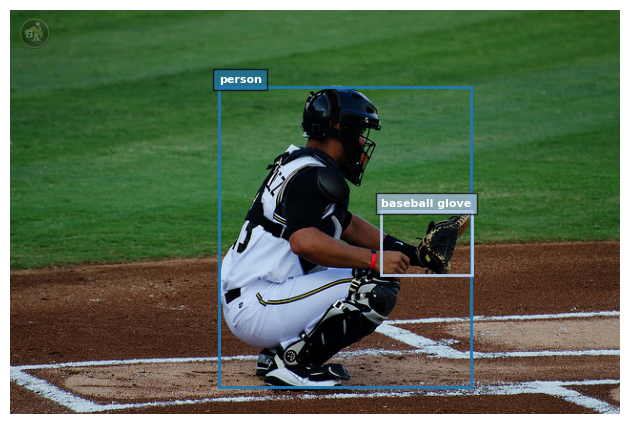

In [54]:
plot_image_with_bboxes(ds_coco, local_index=1457)

### 3. Data Query

MULLER provides a comprehensive suite of query functionalities tailored for AI data lakes:

* Comparison Operators: Supports exact and range matching using `>`,`<`, `>=`, and `<=` for numerical types (`int`/`float`) where the tensor htype is generic.
* Equality and Inequality: Supports `==` and `!=` for `int`, `float`, `str`, and `bool` types (`generic` or `text` htypes). Users can optionally build inverted indexes to significantly accelerate retrieval performance.
* Range Queries: Supports the `BETWEEN` keyword for numerical types (`int`/`float`). This feature requires an inverted index.
* Full-Text Search: Supports the `CONTAINS` operator for `str` types (`text` htype), backed by an inverted index. For Chinese text, tokenization is handled by the open-source Jieba tokenizer.
* Pattern Matching: Supports `LIKE` for regular expression matching on `str` types (`text` htype).
* Boolean Logic: Supports complex query compositions using `AND`, `OR`, and `NOT` logical connectors.
* Pagination: Supports query results with `OFFSET` and `LIMIT` clauses for efficient data sampling.
* Data Aggregation: Supports standard SQL-like aggregation workflows, including `SELECT`, `GROUP BY`, and `ORDER BY`, alongside aggregate functions such as `COUNT`, `AVG`, `MIN`, `MAX`, and `SUM`.
* Vector Similarity Search: Supports high-dimensional vector similarity retrieval based on IVFPQ, HNSW and DISKANN for AI-centric embedding analysis.

In [76]:
ds_toy.commit()
ds_toy.create_index_vectorized("description")

INFO: There is no existing indexes. Start to create index...
INFO: The following batches are already constructed: []
/home/dyvm6xra/dyvm6xrauser08/miniforge3/envs/muller/lib/python3.11/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/dyvm6xra/dyvm6xrauser08/miniforge3/envs/muller/lib/python3.11/site-packages/jieba/__init__.py", line 154, in initialize
    _r

NameError: name 'ds' is not defined

In [85]:
res = ds_toy.filter_vectorized([("description", "CONTAINS", "cat"), ("labels", "<", 4)],  ["OR"])
ds_3_df = str_to_pandas(res)
ds_3_df

,categories,description,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0
1,cat,A domestic short-hair cat with a distinctive t...,1
2,dog,An energetic Golden Retriever sprinting across...,2
3,dog,A focused German Shepherd sitting patiently on...,3


In [83]:
res = ds_toy.filter_vectorized([("labels", ">", 1)])
res.labels.numpy()

array([[2],
       [3],
       [4]])

In [84]:
res = ds_toy.aggregate_vectorized(
        group_by_tensors=['categories'],
        selected_tensors=['labels', 'categories'],
        order_by_tensors=['labels'],
        aggregate_tensors=["*"],)
res

array([['4', 'rabbit', '1'],
       ['2', 'dog', '2'],
       ['0', 'cat', '2']], dtype='<U21')

In [2]:
ds_vec = muller.dataset(path=muller_dataset_root_path + "vec", overwrite=True)
ds_vec.create_tensor(name="embeddings", htype="vector", dtype="float32", dimension=32)

Tensor(key='embeddings')

In [3]:
data = np.random.rand(320000).reshape(10000, 32).astype(np.float32)
ds_vec.embeddings.extend(data)
ds_vec.commit()

'firstdbf9474d461a19e9333c2fd19b46115348f'

In [4]:
ds_vec.create_vector_index("embeddings", index_name="hnsw", index_type="HNSWFLAT", metric="l2", ef_construction=40, m=32)

In [5]:
ds_vec.create_vector_index("embeddings", index_name="flat", index_type="FLAT", metric="l2")

In [6]:
q = np.random.rand(1000, 32)
q

array([[0.54008759, 0.56539336, 0.39909497, ..., 0.70121689, 0.83122774,
        0.79311718],
       [0.03301531, 0.79449733, 0.22090081, ..., 0.62151874, 0.19720933,
        0.71828693],
       [0.43166519, 0.94162655, 0.82156997, ..., 0.67593389, 0.63637473,
        0.39334848],
       ...,
       [0.26295408, 0.05145393, 0.82019782, ..., 0.3236528 , 0.06711882,
        0.15605371],
       [0.70782852, 0.13381654, 0.62001676, ..., 0.14397075, 0.53625036,
        0.08141253],
       [0.0308839 , 0.88060779, 0.01248826, ..., 0.66160382, 0.36246799,
        0.37350343]], shape=(1000, 32))

In [8]:
ds_vec.load_vector_index("embeddings", index_name="flat")
res = ds_vec.vector_search(query_vector=q, tensor_name="embeddings", index_name="flat", topk=1)
res
_, ground_truth = res

In [10]:
ds_vec.load_vector_index("embeddings", index_name="hnsw")
res = ds_vec.vector_search(query_vector=q, tensor_name="embeddings", index_name="hnsw", ef_search=16)

_, res_id = res
recall = np.ones(len(res_id))[(ground_truth==res_id).flatten()].sum() / len(res_id)
recall

np.float64(0.947)

### 4. Version Control

#### 4.1. 1. Checkout a new branch (dev-1), and conduct data annotations (append/pop/update)

In [1]:
import pandas as pd

def str_to_pandas(ds):
    data = {}
    for k, v in ds.numpy().items():
        data[k] = list(v.flatten())
    df = pd.DataFrame(data, columns=list(ds.numpy().keys()))
    return df

def np_to_pandas(ds, col_list, start, end):
    data = {}
    for col in col_list:
        data[col] = ds[col].numpy(aslist=True)[start: end]
    df = pd.DataFrame(data, columns=col_list)
    return df

import muller
muller_dataset_root_path = "/home/dyvm6xra/dyvm6xrauser08/sherry/muller_dataset/"

ds = muller.dataset(path=muller_dataset_root_path + "toy", overwrite=True)
ds.create_tensor('labels', htype='generic', dtype='int')
ds.create_tensor('categories', htype='text')
ds.create_tensor('description', htype='text')
with ds:
    ds.labels.extend([0, 1, 2, 3, 4])
    ds.categories.extend(["cat", "cat", "dog", "dog", "rabbit"])
    ds.description.extend(["A majestic long-haired Maine Coon cat perched on a wooden bookshelf, staring intently at a tree outside with its bright amber eyes.", 
                           "A domestic short-hair cat with a distinctive tuxedo pattern stretching lazily across a velvet sofa in a dimly lit living room.", 
                           "An energetic Golden Retriever sprinting across a vibrant green meadow, its fur glistening under the afternoon sun as it chases a bright yellow tennis ball.", 
                           "A focused German Shepherd sitting patiently on a cobblestone street, wearing a professional service harness and looking up at its handler for the next command.", 
                           "A soft, white lop-eared rabbit nestled in a patch of clover, twitching its pink nose while nibbling on a fresh garden carrot."])

In [2]:
ds = muller.load(path=muller_dataset_root_path + "toy@main")
ds.checkout("dev-1", create=True)
# Append rows
ds.labels.extend([50, 60, 70])
ds.categories.extend(["cat", "bird", "cat"])
ds.description.extend(["An inquisitive ginger tabby cat standing on its hind legs, reaching out with its paws toward a feathered toy during an active play session.", 
                       "A sleek all-black cat curled up in a deep sleep on a soft, cream-colored fleece blanket, enjoying a quiet afternoon nap in a cozy indoor setting.", 
                       "A vibrant Macaw with brilliant red, blue, and yellow plumage, perched firmly on a weathered wooden branch while looking curiously into the distance."])
# Update rows
ds.labels[3] = 30
# Delete rows
ds.pop(1)
ds.commit('commit on dev-1')
df = str_to_pandas(ds)
df

2026-01-14 19:43:15,987 - version_control.py[line:806] - auto_commit - 23456246728512 - 3198839 - Auto committing to branch 'main' before checkout as currently at head node.
/home/dyvm6xra/dyvm6xrauser08/sherry/MULLER/muller/core/chunk/interface/chunk_engine_update_interface.py:184: UserWarning: After update, some chunks were suboptimal. Be careful when doing lots of updates that modify the sizes of samples by a large amount, these can heavily impact read performance!
  warnings.warn(


,categories,description,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0
1,dog,An energetic Golden Retriever sprinting across...,2
2,dog,A focused German Shepherd sitting patiently on...,30
3,rabbit,"A soft, white lop-eared rabbit nestled in a pa...",4
4,cat,An inquisitive ginger tabby cat standing on it...,50
5,bird,A sleek all-black cat curled up in a deep slee...,60
6,cat,"A vibrant Macaw with brilliant red, blue, and ...",70


In [3]:
ds.log()

---------------
MULLER_F Version Log
---------------

Current Branch: dev-1
Commit : d1a2eba5cacc91e74f46e906e690cfdf2974b3da (dev-1) 
Author : public
Time   : 2026-01-14 11:43:16
Message: commit on dev-1

Commit : firstdbf9474d461a19e9333c2fd19b46115348f (main) 
Author : public
Time   : 2026-01-14 11:43:15
Message: auto commit before checkout to dev-1



#### 4.2. Go back to the main branch, then checkout a new branch (dev-2), and conduct data annotations (append/pop/update)

In [4]:
ds = muller.load(path=muller_dataset_root_path + "toy@main")
ds.checkout("dev-2", create=True)
# Append rows
ds.labels.extend([500, 600, 700, 800])
ds.categories.extend(["cat", "cat", "dog", "bird"])
ds.description.extend(["A fluffy orange tabby cat lounges lazily in a sunny window, its green eyes half-closed in contentment.",
                          "Two playful kittens chase each other across the living room floor, their tiny paws pattering on the hardwood.",
                          "A golden retriever bounds through the park with a tennis ball in its mouth, tail wagging enthusiastically.",
                          "A vibrant blue jay perches on a snow-covered branch, its colorful feathers contrasting beautifully against the white winter landscape."])
# Update rows
ds.labels[3] = 300
ds.labels[4] = 400
# Delete rows
ds.pop([1, 2])
ds.commit('commit on dev-2')
df = str_to_pandas(ds)
df

/home/dyvm6xra/dyvm6xrauser08/sherry/MULLER/muller/core/chunk/interface/chunk_engine_update_interface.py:184: UserWarning: After update, some chunks were suboptimal. Be careful when doing lots of updates that modify the sizes of samples by a large amount, these can heavily impact read performance!
  warnings.warn(


,categories,description,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0
1,dog,A focused German Shepherd sitting patiently on...,300
2,rabbit,"A soft, white lop-eared rabbit nestled in a pa...",400
3,cat,A fluffy orange tabby cat lounges lazily in a ...,500
4,cat,Two playful kittens chase each other across th...,600
5,dog,A golden retriever bounds through the park wit...,700
6,bird,A vibrant blue jay perches on a snow-covered b...,800


In [7]:
ds.checkout("main")
ds.log()

---------------
MULLER_F Version Log
---------------

Current Branch: main
Commit : firstdbf9474d461a19e9333c2fd19b46115348f (main) 
Author : public
Time   : 2026-01-14 11:43:15
Message: auto commit before checkout to dev-1



#### 4.3. Go back to the main branch, then merge dev-1 first (Note: we adopt the pop operations in dev-1)

In [8]:
ds.checkout('main')
ds.branches

{'main': {'based_on': None,
  'create_time': datetime.datetime(2026, 1, 14, 11, 43, 12, 310372)},
 'dev-1': {'based_on': 'main',
  'create_time': datetime.datetime(2026, 1, 14, 11, 43, 16, 10257)},
 'dev-2': {'based_on': 'main',
  'create_time': datetime.datetime(2026, 1, 14, 11, 43, 23, 732673)}}

In [9]:
ds.merge('dev-1', pop_resolution='theirs')

/home/dyvm6xra/dyvm6xrauser08/sherry/MULLER/muller/core/chunk/interface/chunk_engine_update_interface.py:184: UserWarning: After update, some chunks were suboptimal. Be careful when doing lots of updates that modify the sizes of samples by a large amount, these can heavily impact read performance!
  warnings.warn(



#### 4.4. Check the diff between the main branch and dev-1 branch, then merge the dev-2 branch

In [10]:
from pprint import pprint
conflict_cols, conflict_records = ds.detect_merge_conflict("dev-2", show_value=True)
pprint(conflict_records)

{'categories': {'app_ori_idx': [4, 5, 6],
                'app_ori_values': [array(['cat'], dtype='<U3'),
                                   array(['bird'], dtype='<U4'),
                                   array(['cat'], dtype='<U3')],
                'app_tar_idx': [3, 4, 5, 6],
                'app_tar_values': [array(['cat'], dtype='<U3'),
                                   array(['cat'], dtype='<U3'),
                                   array(['dog'], dtype='<U3'),
                                   array(['bird'], dtype='<U4')],
                'del_ori_idx': [],
                'del_ori_values': [],
                'del_tar_idx': [2],
                'del_tar_values': [array(['dog'], dtype='<U3')],
                'update_values': {'update_ori': [], 'update_tar': []}},
 'description': {'app_ori_idx': [4, 5, 6],
                 'app_ori_values': [array(['An inquisitive ginger tabby cat standing on its hind legs, reaching out with its paws toward a feathered toy during an active pl

In [11]:
ds.merge("dev-2", append_resolution="both", pop_resolution="ours", update_resolution="theirs")
df = str_to_pandas(ds)
df

,categories,description,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0
1,dog,An energetic Golden Retriever sprinting across...,2
2,dog,A focused German Shepherd sitting patiently on...,300
3,rabbit,"A soft, white lop-eared rabbit nestled in a pa...",400
4,cat,An inquisitive ginger tabby cat standing on it...,50
5,bird,A sleek all-black cat curled up in a deep slee...,60
6,cat,"A vibrant Macaw with brilliant red, blue, and ...",70
7,cat,A fluffy orange tabby cat lounges lazily in a ...,500
8,cat,Two playful kittens chase each other across th...,600
9,dog,A golden retriever bounds through the park wit...,700


#### 4.5. Based on the main branch, create a new branch dev-3, and add a new column

In [13]:
import numpy as np
with ds:
    #ds.checkout("dev-3", create=True)
    #ds.create_tensor("features", htype="generic", dtype="float")
    ds.features.extend(np.arange(0, 1.1, 0.1))
    ds.commit()
df = str_to_pandas(ds)
df

,categories,description,features,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0.0,0
1,dog,An energetic Golden Retriever sprinting across...,0.1,2
2,dog,A focused German Shepherd sitting patiently on...,0.2,300
3,rabbit,"A soft, white lop-eared rabbit nestled in a pa...",0.3,400
4,cat,An inquisitive ginger tabby cat standing on it...,0.4,50
5,bird,A sleek all-black cat curled up in a deep slee...,0.5,60
6,cat,"A vibrant Macaw with brilliant red, blue, and ...",0.6,70
7,cat,A fluffy orange tabby cat lounges lazily in a ...,0.7,500
8,cat,Two playful kittens chase each other across th...,0.8,600
9,dog,A golden retriever bounds through the park wit...,0.9,700


#### 4.6. Go back to the main Branch, and merge branch dev-3

In [14]:
ds.checkout("main")
ds.merge("dev-3")
df = str_to_pandas(ds)
df

,categories,description,features,labels
0,cat,A majestic long-haired Maine Coon cat perched ...,0.0,0
1,dog,An energetic Golden Retriever sprinting across...,0.1,2
2,dog,A focused German Shepherd sitting patiently on...,0.2,300
3,rabbit,"A soft, white lop-eared rabbit nestled in a pa...",0.3,400
4,cat,An inquisitive ginger tabby cat standing on it...,0.4,50
5,bird,A sleek all-black cat curled up in a deep slee...,0.5,60
6,cat,"A vibrant Macaw with brilliant red, blue, and ...",0.6,70
7,cat,A fluffy orange tabby cat lounges lazily in a ...,0.7,500
8,cat,Two playful kittens chase each other across th...,0.8,600
9,dog,A golden retriever bounds through the park wit...,0.9,700


In [15]:
ds.log()

---------------
MULLER_F Version Log
---------------

Current Branch: main
Commit : 4eed19e4405a03e879a870ac06be174eb4938d7a (main) 
Author : public
Time   : 2026-01-14 11:49:24
Message: Merge 9cf7f343613cfcc0c9e20d72cf6c8c9443b39d01 into main

Commit : 9cf7f343613cfcc0c9e20d72cf6c8c9443b39d01 (dev-3) 
Author : public
Time   : 2026-01-14 11:48:05
Message: None

Commit : 00a386095cb1f0b24a125bc6192f87dcd8299963 (main) 
Author : public
Time   : 2026-01-14 11:44:25
Message: Merge 65d35f09a52345c91609caf36696d290c0f192f3 into main

Commit : 7db2cbe3dcee73555cbfc2197a7b92ca2341d9d9 (main) 
Author : public
Time   : 2026-01-14 11:44:13
Message: Merge d1a2eba5cacc91e74f46e906e690cfdf2974b3da into main

Commit : d1a2eba5cacc91e74f46e906e690cfdf2974b3da (dev-1) 
Author : public
Time   : 2026-01-14 11:43:16
Message: commit on dev-1

Commit : 65d35f09a52345c91609caf36696d290c0f192f3 (dev-2) 
Author : public
Time   : 2026-01-14 11:43:23
Message: commit on dev-2

Commit : firstdbf9474d461a19e9333c2f